In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from sklearn.ensemble import IsolationForest
import matplotlib.dates as mdates


# 1. Import dữ liệu đã làm sạch
df = pd.read_csv("../data/processed/03_4_country_population_summary.csv.gz", compression='gzip')

In [2]:
df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths,New_cases_MA7,New_deaths_MA7,Growth_Rate
0,2020-01-04,CN,China,WPR,1.0,0.0,1,0,1.000000,0.0,0.0
1,2020-01-05,CN,China,WPR,0.0,0.0,1,0,0.500000,0.0,-100.0
2,2020-01-06,CN,China,WPR,3.0,0.0,4,0,1.333333,0.0,0.0
3,2020-01-07,CN,China,WPR,0.0,0.0,4,0,1.000000,0.0,-100.0
4,2020-01-08,CN,China,WPR,0.0,0.0,4,0,0.800000,0.0,0.0


## FEATURE ENGINEERING

### 1. Lag Features (Dịch chuyển thời gian)
**Ý nghĩa:**

* Lấy số ca 7 và 14 ngày trước của mỗi quốc gia.

* Mỗi nước được xử lý riêng (nhờ groupby("country")).

* Dùng để mô hình học được tính chu kỳ và độ trễ của dịch bệnh.

**Ví dụ:**
Ngày 10/1 → giá trị cases_lag_7 = số ca ngày 3/1.

→ Lag 7 rất quan trọng vì COVID có chu kỳ ~7 ngày (đặc biệt do hiệu ứng tuần và thời gian ủ bệnh).

-> Bùng phát COVID thường có hiệu ứng sau 10–14 ngày → lag 14 giúp mô hình học được chu kỳ dài hơn.

In [2]:
# dịch chuyển thời gian
df["Cases_lag_7"] = df.groupby("Country")["New_cases"].shift(7)
df["Cases_lag_14"] = df.groupby("Country")["New_cases"].shift(14)

### 2. Rolling Window Features (Trung bình trượt)


**Ý nghĩa:**

* Tính trung bình 7 ngày gần nhất cho mỗi quốc gia.

* Giúp làm mượt dữ liệu, loại bỏ nhiễu do báo cáo không đều (ví dụ WHO hay báo dồn vào thứ 2).

**Ví dụ:**
Giá trị ngày 10/1 =
mean(cases ngày 4 → 10)

→ Biểu diễn xu hướng dịch chính xác hơn số liệu thô.

In [3]:
# Xóa trực tiếp trên df gốc
df.drop(['New_cases_MA7', 'New_deaths_MA7'], axis=1, inplace=True)

In [4]:
# Tính trung bình động 7 ngày
df["Cases_roll_7"] = df.groupby("Country")["New_cases"].rolling(7).mean().reset_index(level=0, drop=True) 
df["Deaths_roll_7"] = df.groupby("Country")["New_deaths"].rolling(7).mean().reset_index(level=0, drop=True)

### 3. Differencing (Hiệu số ngày liền kề)
**Ý nghĩa:**

* Tính mức chênh lệch ca nhiễm so với ngày hôm trước.

* Giúp mô hình học tốc độ tăng/giảm.

**Ví dụ:**

* Ngày 10/1: 500 ca

* Ngày 9/1: 400 ca

→ cases_diff = 500 - 400 = 100

**Ứng dụng:**

* Phát hiện giai đoạn bùng phát (diff > 0)

* Phát hiện dịch đang giảm (diff < 0)

* Mô hình dự báo thường tốt hơn khi dùng “dịch hóa” thay vì giá trị tuyệt đối (stationary data)

In [5]:
df["Cases_diff"] = df.groupby("Country")["New_cases"].diff()

## 4.2. Thống kê mô tả & Phân tích dữ liệu nhiễu

Phần này chứng minh tính biến động và các điểm bất thường của dữ liệu.

### BIỂU ĐỒ: GROWTH RATE (tốc độ tăng trưởng ca bệnh)

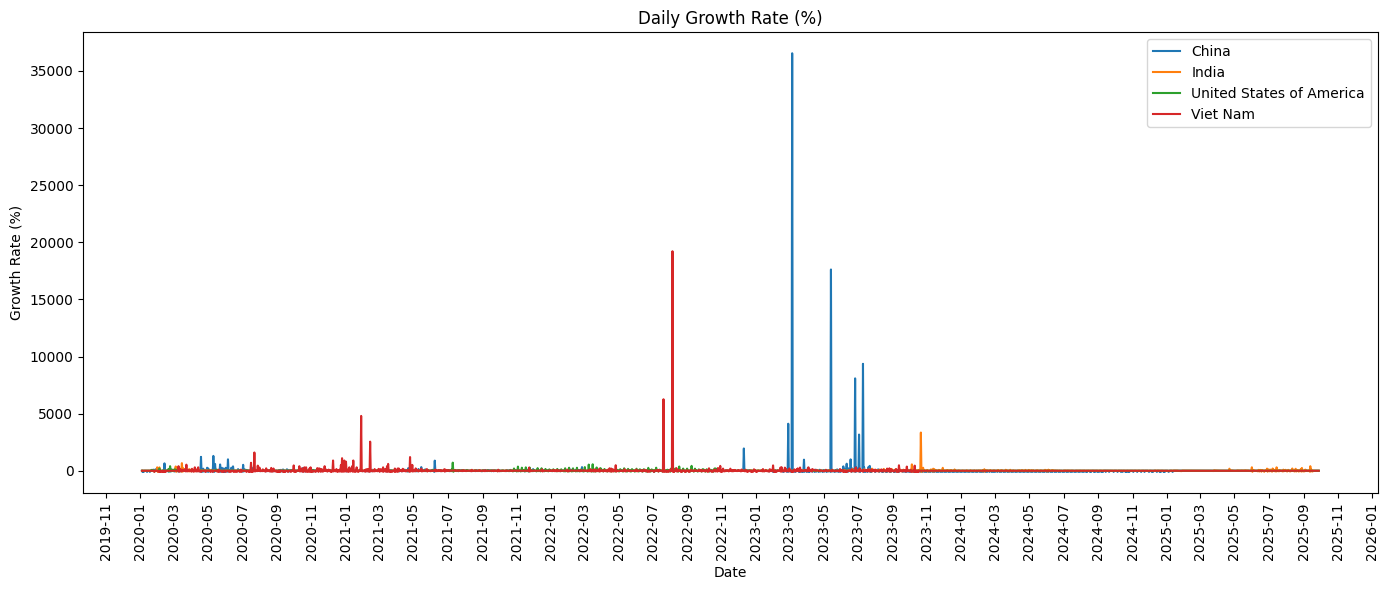

In [ ]:
import matplotlib.dates as mdates
plt.figure(figsize=(14,6))
for c in df["Country"].unique():
    sub = df[df["Country"] == c]
    plt.plot(sub["Date_reported"], sub["Growth_Rate"], label=c)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Cách 2 tháng hiện 1 lần
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title("Daily Growth Rate (%)")
plt.xlabel("Date")
plt.ylabel("Growth Rate (%)")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("../results/charts/daily_growth_rate_covid19_cases.png")
plt.show()
plt.close()

Tốc độ tăng trưởng không đồng đều, xuất hiện các giá trị tăng trưởng rất mạnh -> dự báo nhiều đợt bùng dịch

<Figure size 1000x600 with 0 Axes>

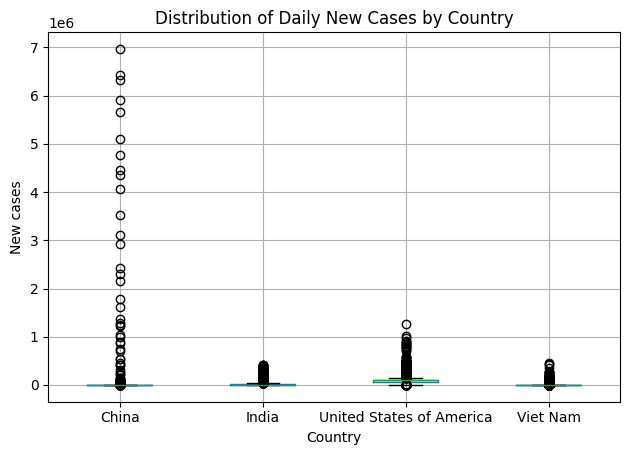

In [7]:
plt.figure(figsize=(10, 6))
df.boxplot(column="New_cases", by="Country")
plt.title("Distribution of Daily New Cases by Country")
plt.suptitle("")
plt.xlabel("Country")
plt.ylabel("New cases")
plt.tight_layout()
plt.savefig("../results/charts/boxplot_new_cases_by_country.png")
plt.show()
plt.close()

**Nhận xét:**

* Biểu đồ Boxplot cho thấy dữ liệu có độ phân tán cực lớn (độ trải giữa các tứ phân vị rộng)
và xuất hiện dày đặc các điểm ngoại lai (outliers) nằm ngoài râu của biểu đồ.

-> Điều này khẳng định dữ liệu không tuân theo phân phối chuẩn, gây khó khăn cho các mô hình hồi quy tuyến tính.

Vì có quá nhiều điểm ngoại lai. Ta sẽ dùng **Isolation Forest** để tìm ngày bùng dịch bất thường

### BIỂU ĐỒ : ANOMALY DETECTION (Isolation Forest)

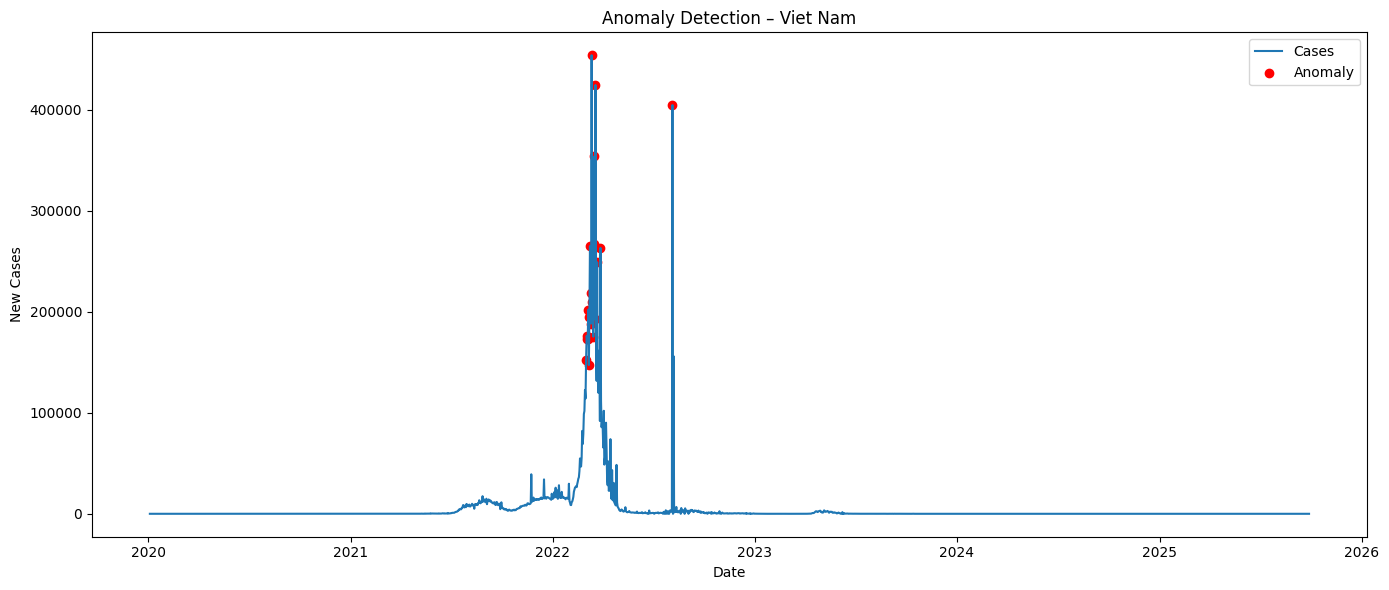

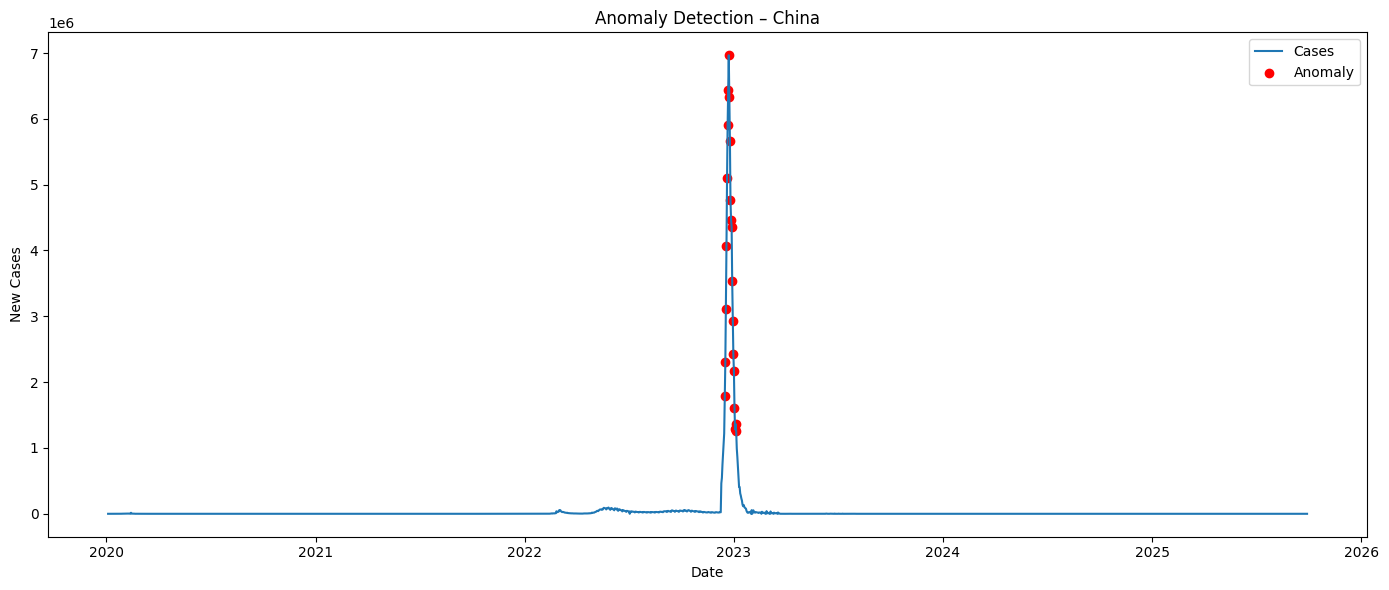

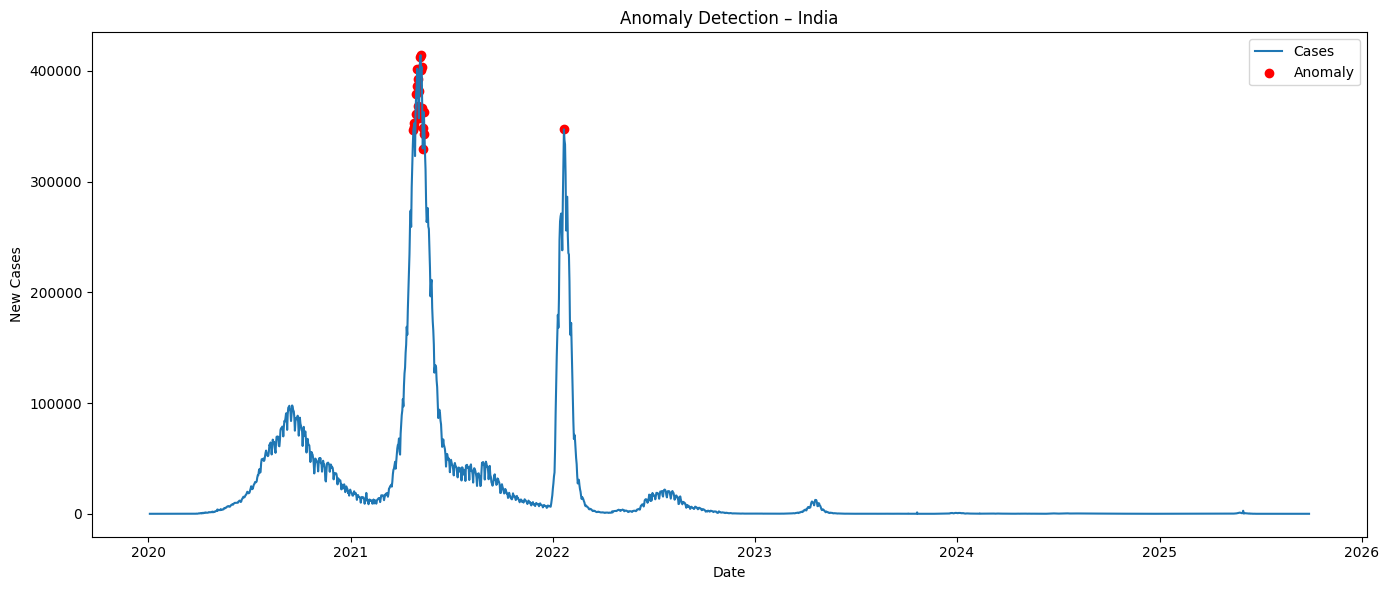

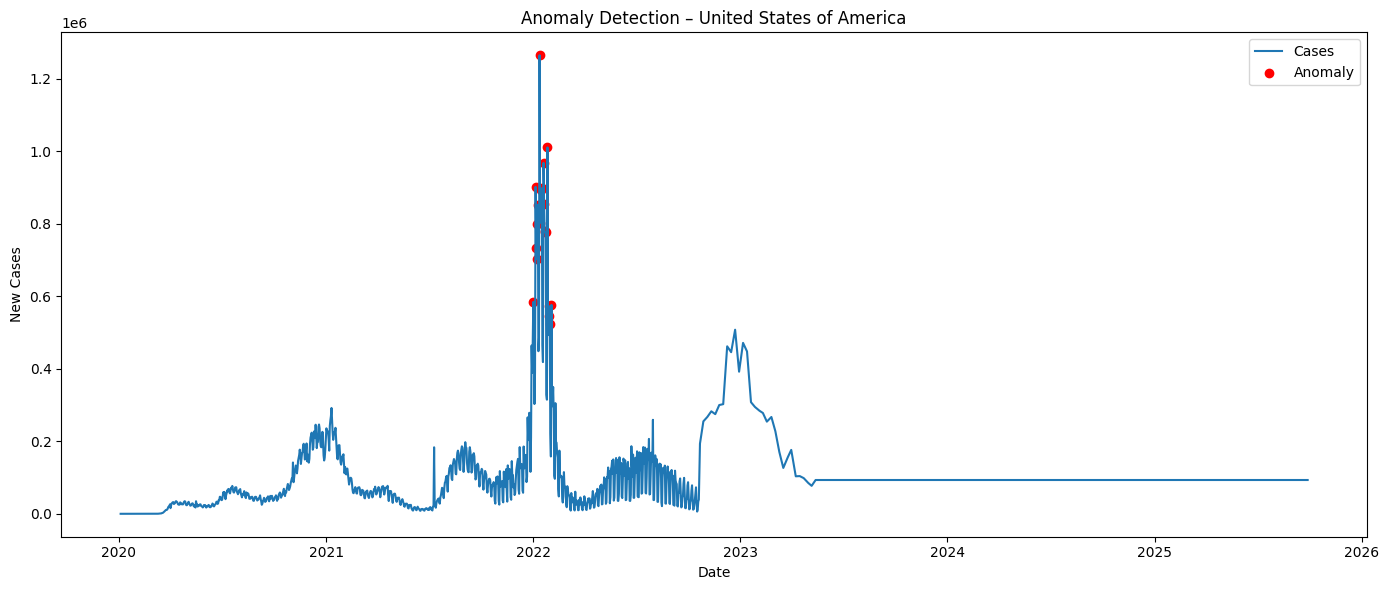

In [ ]:
for c in df["Country"].unique():
    sub = df[df["Country"] == c].copy()
    model = IsolationForest(contamination=0.01, random_state=42)
    sub["anomaly"] = model.fit_predict(sub[["New_cases"]])

    plt.figure(figsize=(14,6))
    plt.plot(sub["Date_reported"], sub["New_cases"], label="Cases")
    plt.scatter(
        sub[sub["anomaly"] == -1]["Date_reported"],
        sub[sub["anomaly"] == -1]["New_cases"],
        color="red",
        label="Anomaly"
    )
    plt.title(f"Anomaly Detection – {c}")
    plt.xlabel("Date")
    plt.ylabel("New Cases")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../results/charts/anomaly_detection_covid19_{c.replace(' ', '_').lower()}.png")
    plt.show()
    plt.close()

**Ý nghĩa:**

* Các điểm màu đỏ được thuật toán Isolation Forest nhận diện là các giá trị bất thường.

* Đây thường là các đỉnh sóng dịch hoặc do nhiễu trong việc nhập liệu (cộng dồn số liệu).

* Việc mô hình nhận diện được các điểm này giúp tăng khả năng xử lý nhiễu trong giai đoạn dự báo.

**Nhận xét:**


## 4.3. EDA

In [12]:
df["Date_reported"] = pd.to_datetime(df["Date_reported"])

### 4.3.1. Phân tích xu hướng (Time-series Trends)
Phần này đi sâu vào tính chất chuỗi thời gian (Trend & Seasonality).

Mục tiêu: Hiểu đặc tính chuỗi thời gian (Trend, Seasonality).

####  Biểu đồ: TREND CASES – CA NHIỄM THEO THỜI GIAN

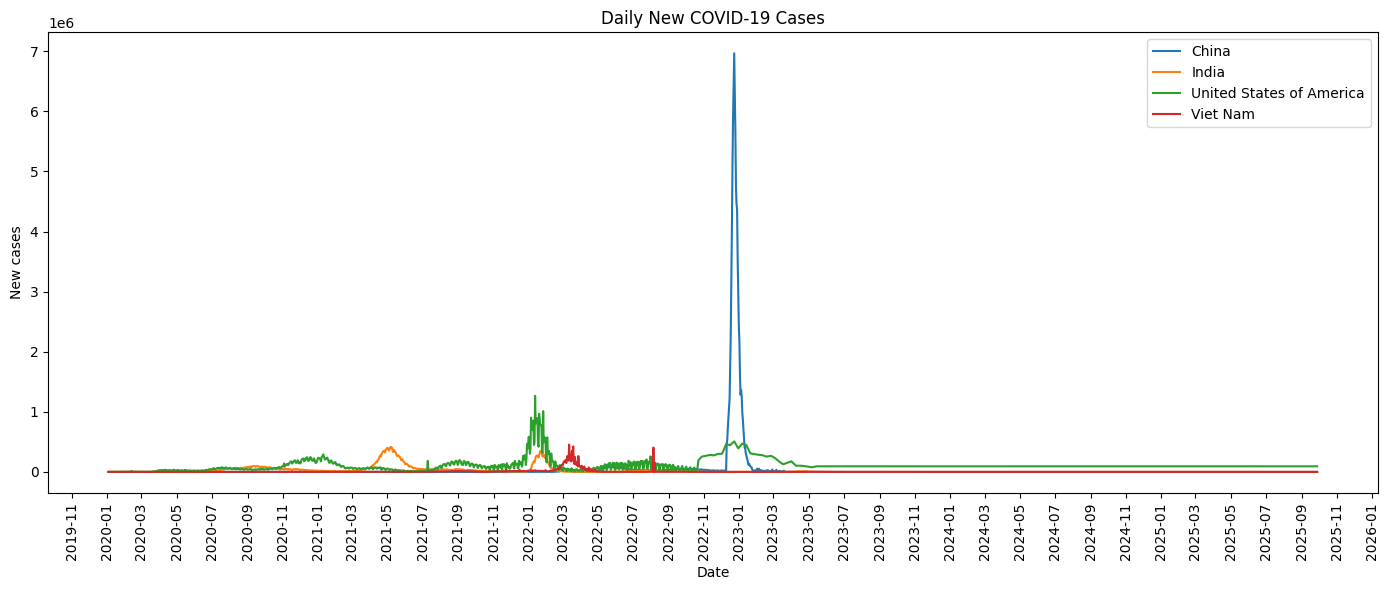

In [ ]:
plt.figure(figsize=(14, 6))
for c in df["Country"].unique():
    temp = df[df["Country"] == c]
    plt.plot(temp["Date_reported"], temp["New_cases"], label=c)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Cách 2 tháng hiện 1 lần
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title("Daily New COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("New cases")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("../results/charts/daily_new_covid19_cases.png")
plt.show()
plt.close()

Biểu đồ số ca nhiễm mới hàng ngày cho thấy xu hướng tăng mạnh vào các giai đoạn bùng phát và giảm dần sau khi các biện pháp giãn cách hoặc tiêm chủng được áp dụng.

#### Biểu đồ: Rolling mean 7 ngày (Loại nhiễu)
Lý do chọn 7: Loại bỏ biến động cuối tuần (thứ 7, CN thường ít báo cáo hơn)

<Figure size 1400x600 with 0 Axes>

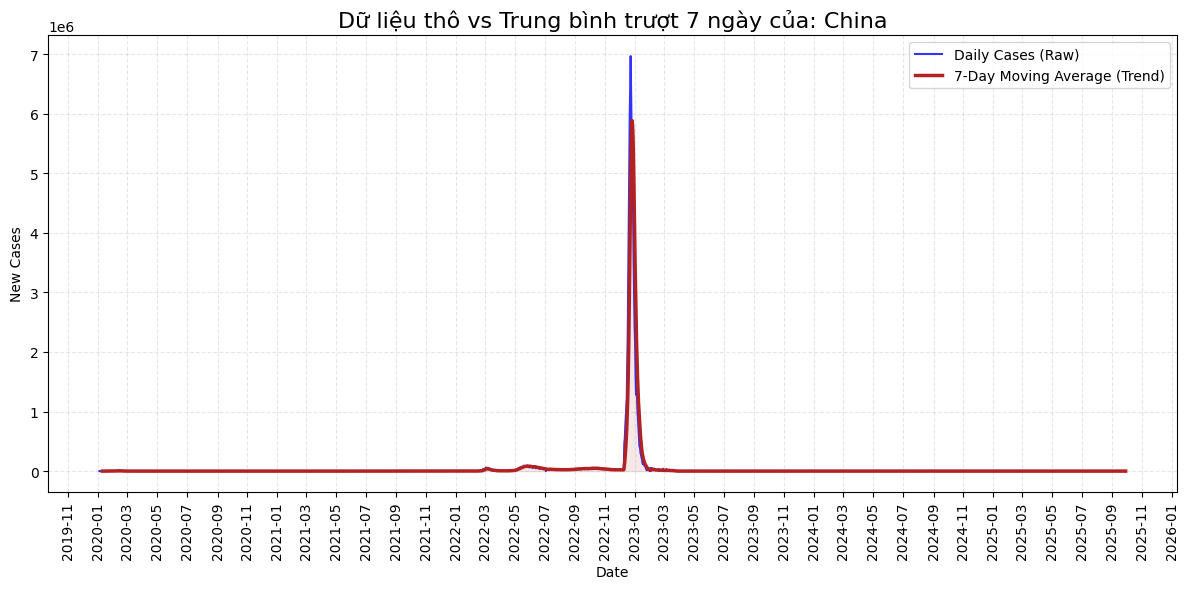

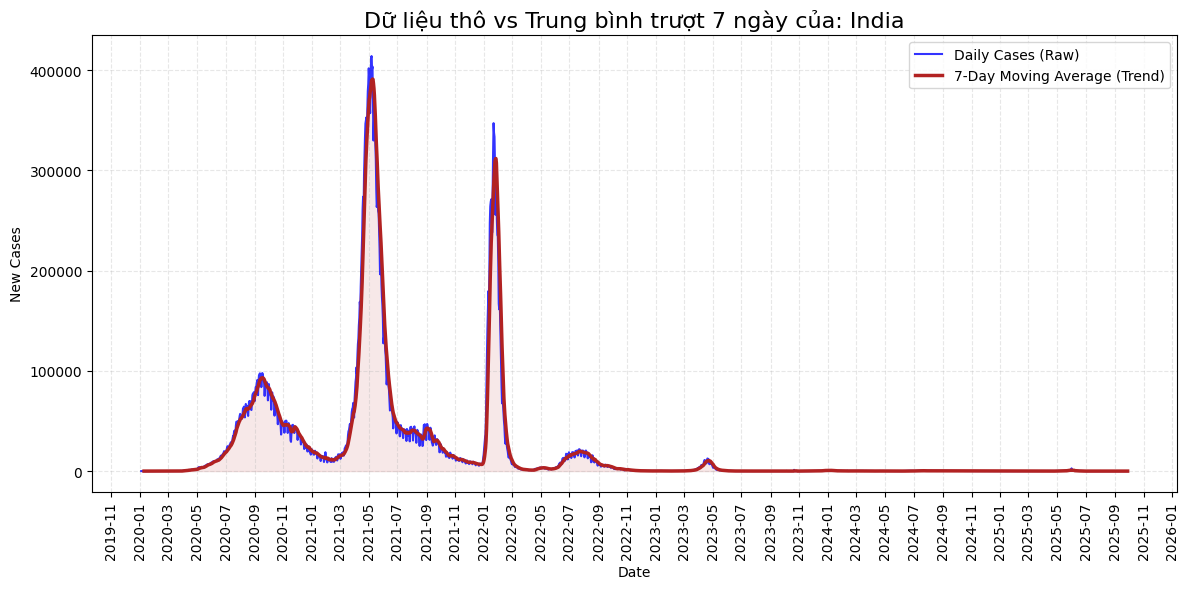

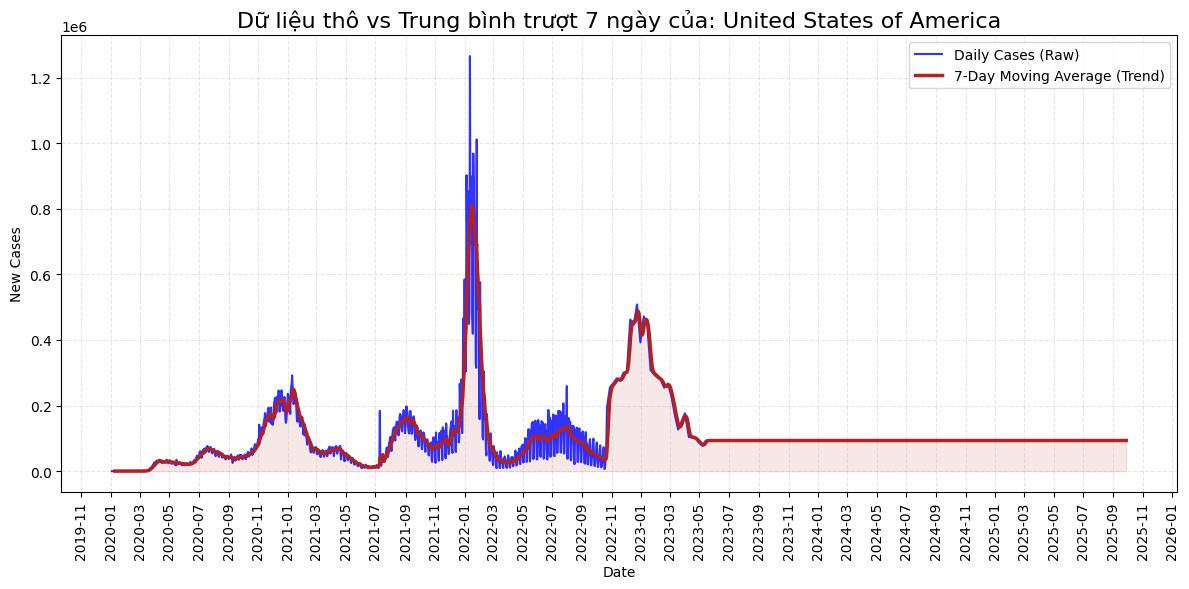

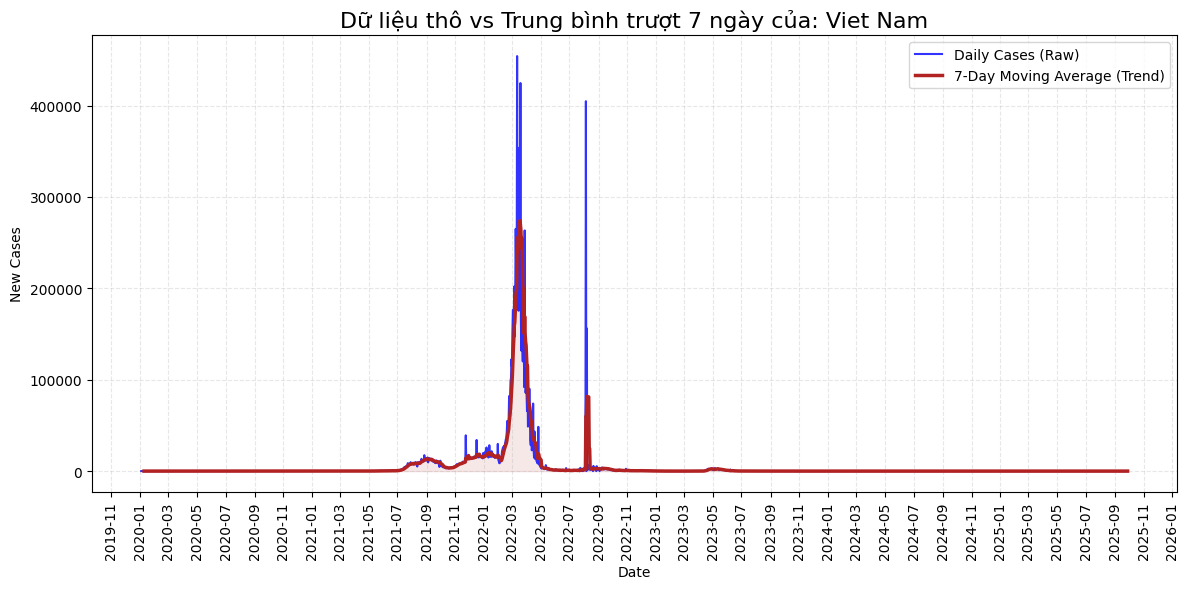

In [13]:
plt.figure(figsize=(14, 6))
for c in df["Country"].unique():
    df_sub = df[df["Country"] == c].sort_values("Date_reported").copy()

    # Tính trung bình trượt 7 ngày (7-day Rolling Average)
    df_sub["MA7"] = df_sub["New_cases"].rolling(window=7).mean()

    plt.figure(figsize=(12, 6))

    # Vẽ dữ liệu gốc (làm mờ đi để làm nền)
    plt.plot(df_sub["Date_reported"], df_sub["New_cases"], 
            color='blue', alpha= 0.8, label='Daily Cases (Raw)')

    # Vẽ đường trung bình trượt (Nổi bật lên)
    plt.plot(df_sub["Date_reported"], df_sub["MA7"], 
            color='firebrick', linewidth=2.5, label='7-Day Moving Average (Trend)')

    # Tô màu vùng dưới đường biểu đồ (Area chart effect)
    plt.fill_between(df_sub["Date_reported"], df_sub["MA7"], 
                    color='firebrick', alpha=0.1)

    plt.title(f"Dữ liệu thô vs Trung bình trượt 7 ngày của: {c}", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("New Cases")
    plt.legend()
    plt.grid(alpha=0.3, linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Cách 2 tháng hiện 1 lần
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"../results/charts/covid19_trend_{c.replace(' ', '_')}.png")
    plt.show()
    plt.close()

**Nhận xét:**

* Đường trung bình trượt giúp loại bỏ biến động ngày cuối tuần (hiệu ứng mùa vụ tuần), làm rõ xu hướng tăng/giảm của dịch.
 
* Đây là biến đặc trưng (feature) quan trọng đầu tiên được đưa vào mô hình Machine Learning.

#### BIỂU ĐỒ: SEASONAL DECOMPOSITION (Trend – Seasonal – Residual)
Mục đích: Tách Trend, Seasonality và Residual

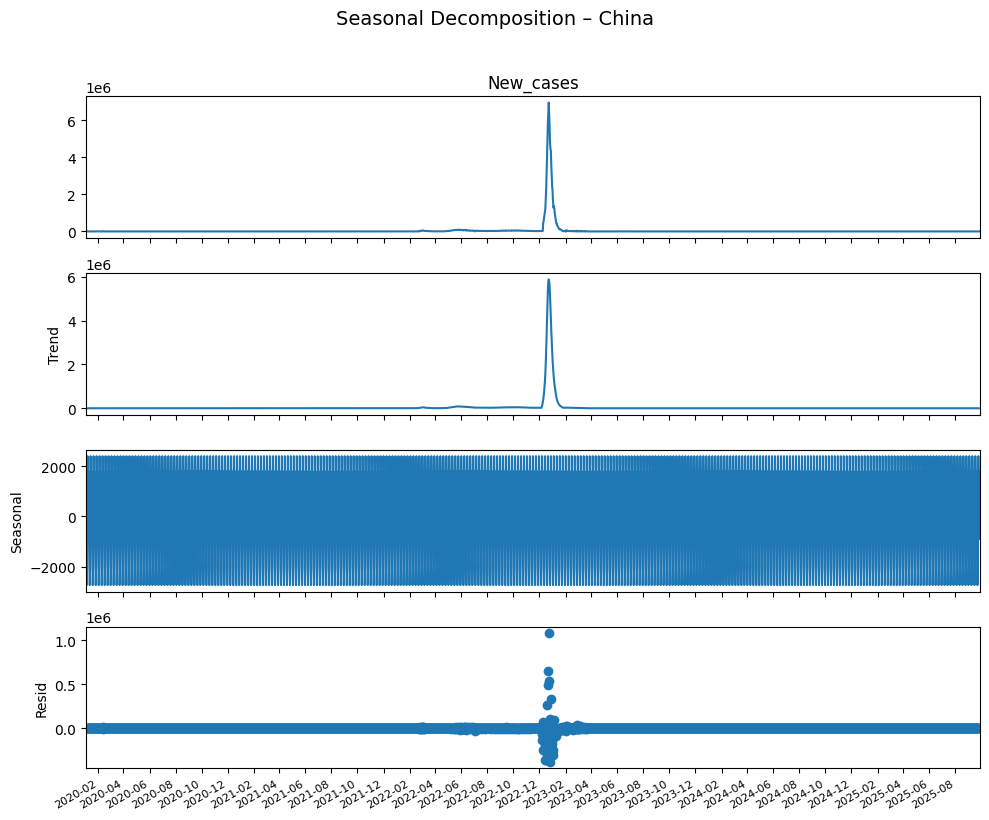

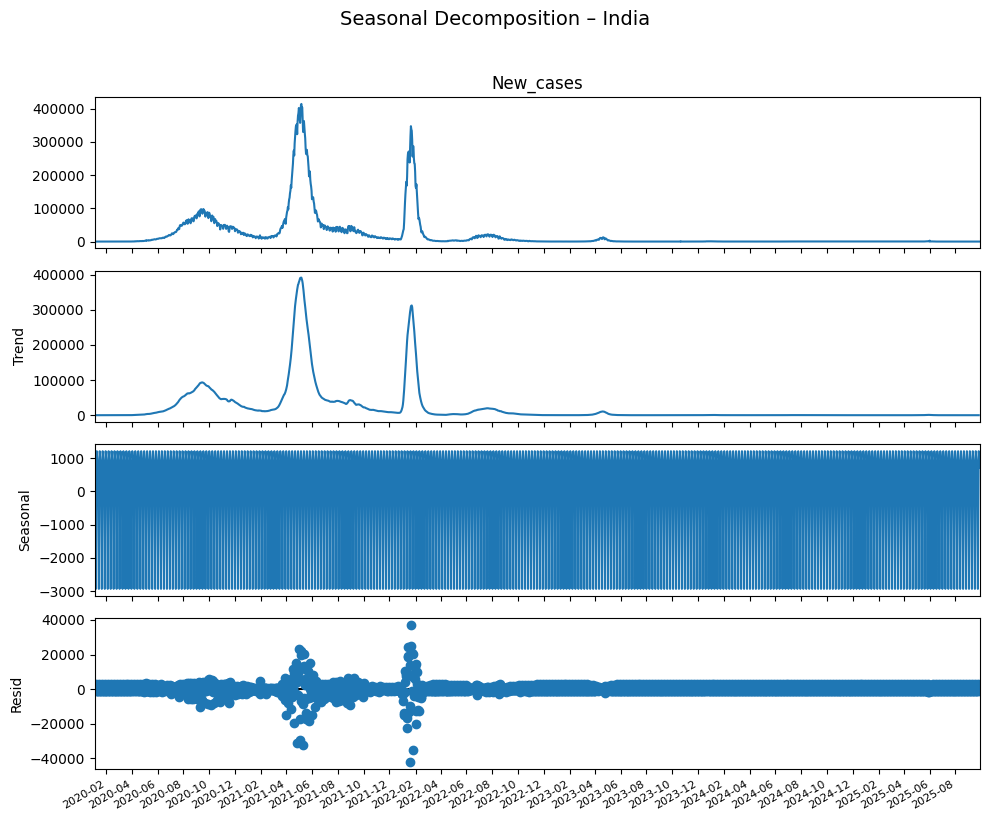

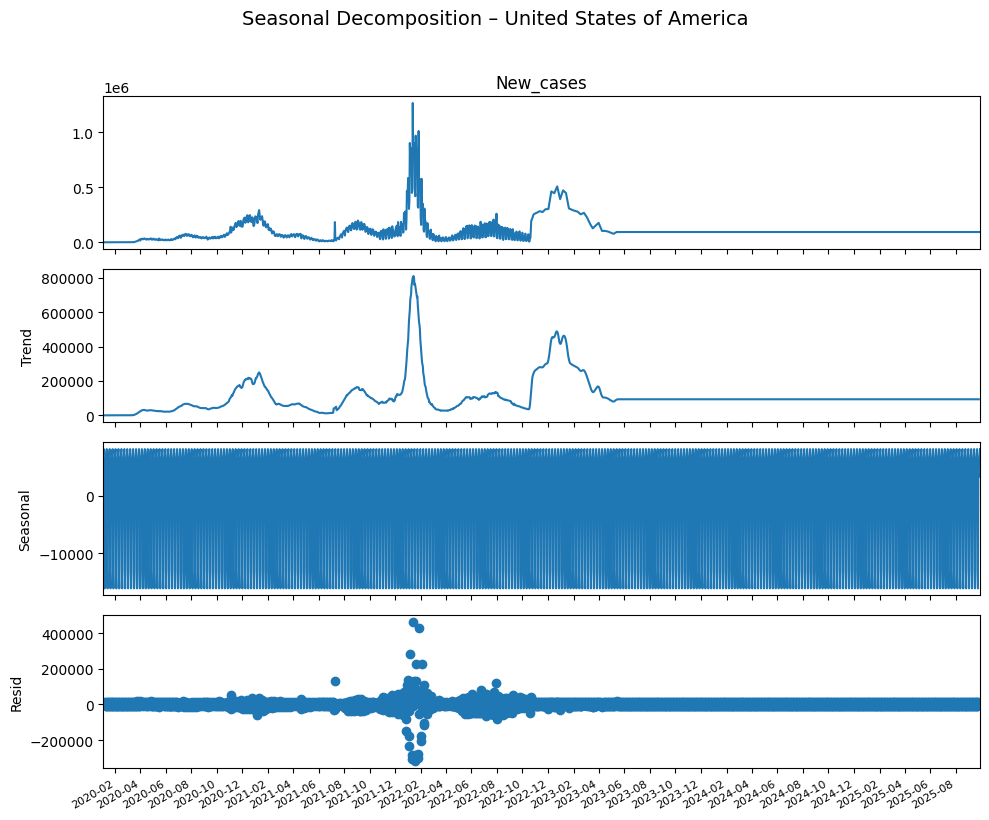

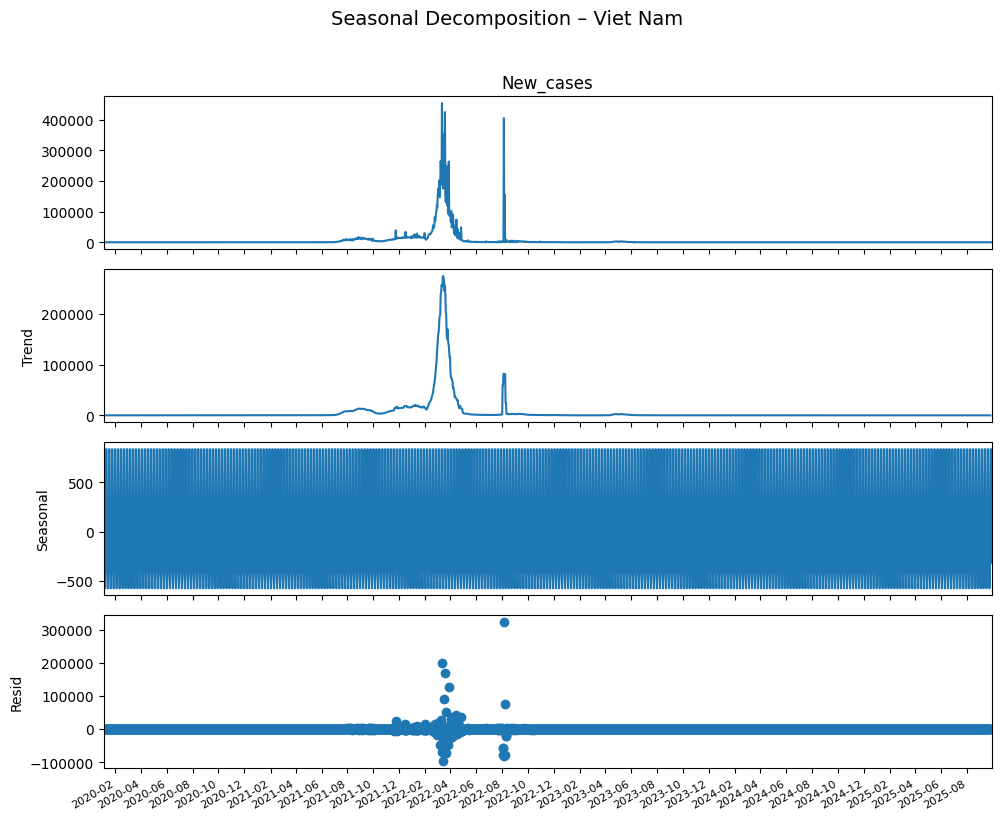

In [14]:
import matplotlib.dates as mdates
for c in df["Country"].unique():
    # Lọc dữ liệu
    sub = df[df["Country"] == c].set_index("Date_reported")

    series = sub["New_cases"].dropna() 

    result = seasonal_decompose(series, model="additive", period=7)

    fig = result.plot()
    
    fig.set_size_inches(10, 8)

    plt.suptitle(f"Seasonal Decomposition – {c}", fontsize=14, y=1.02)

    for ax in fig.axes:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', labelsize=8)

    fig.autofmt_xdate()

    plt.tight_layout()
  
    safe_name = c.replace(' ', '_').lower()
    plt.savefig(f"../results/charts/seasonal_decomposition_covid19_{safe_name}.png", bbox_inches='tight')
    
    plt.show()
    plt.close(fig)

**Nhận xét:**
* Kết quả phân tách cho thấy tính chu kỳ (Seasonal) rất rõ rệt với tần suất 7 ngày.

* Phần dư (Resid) dao động mạnh tại các thời điểm bùng dịch, cho thấy các yếu tố ngẫu nhiên
đóng vai trò lớn bên cạnh xu hướng chính (Trend).


## 4.3.2. Phân tích so sánh (Comparative Analysis)
Mục tiêu: Đánh giá quy mô dịch bệnh giữa các nước nổi bật.

### Bản đồ phân bố địa lý (Choropeleth Map)
Mục đích: Cái nhìn trực quan toàn cầu

In [ ]:
import plotly.express as px

df_latest = df.groupby("Country")[["Cumulative_cases", "Cumulative_deaths"]].max().reset_index()

# Vẽ bản đồ
fig = px.choropleth(df_latest, 
                    locations="Country",         # Cột tên quốc gia
                    locationmode='country names',# Báo cho plotly biết đây là tên nước
                    color="Cumulative_cases",  # Tô màu dựa trên số ca
                    hover_name="Country",   
                    hover_data={
                        "Cumulative_cases": ":,",  # Format thêm dấu phẩy ngăn cách hàng nghìn
                        "Cumulative_deaths": ":,"  
                    },     
                    color_continuous_scale=px.colors.sequential.Reds, # Chọn tông màu
                    title="Global COVID-19 Cumulative Cases Distribution")

fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    geo=dict(
        showframe=False,        # Ẩn khung viền
        showcoastlines=False,   # Ẩn đường bờ biển 
        projection_type='natural earth'
    )
)
fig.write_html("../results/charts/global_covid19_cumulative_cases_map.html")
fig.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_18912\1212213464.py:6: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(df_latest,


#### BIỂU ĐỒ: CASES PER 1M POPULATION 
Để đánh giá quy mô dịch bệnh một cách chính xác. Ta so sánh số ca trên dân số mới phản ánh đúng mức độ nghiêm trọng.

In [16]:
# thêm dữ liệu dân số
df_country = pd.read_csv("../data/processed/02_country_population_summary.csv.gz", compression='gzip')
mapping_dict = df_country.set_index("Country")["Population"]
df["Population"] = df["Country"].map(mapping_dict)

In [17]:
df["Cases_per_1M"] = (df["New_cases"] / df["Population"]) * 1_000_000
df["Deaths_per_1M"] = (df["New_deaths"] / df["Population"]) * 1_000_000

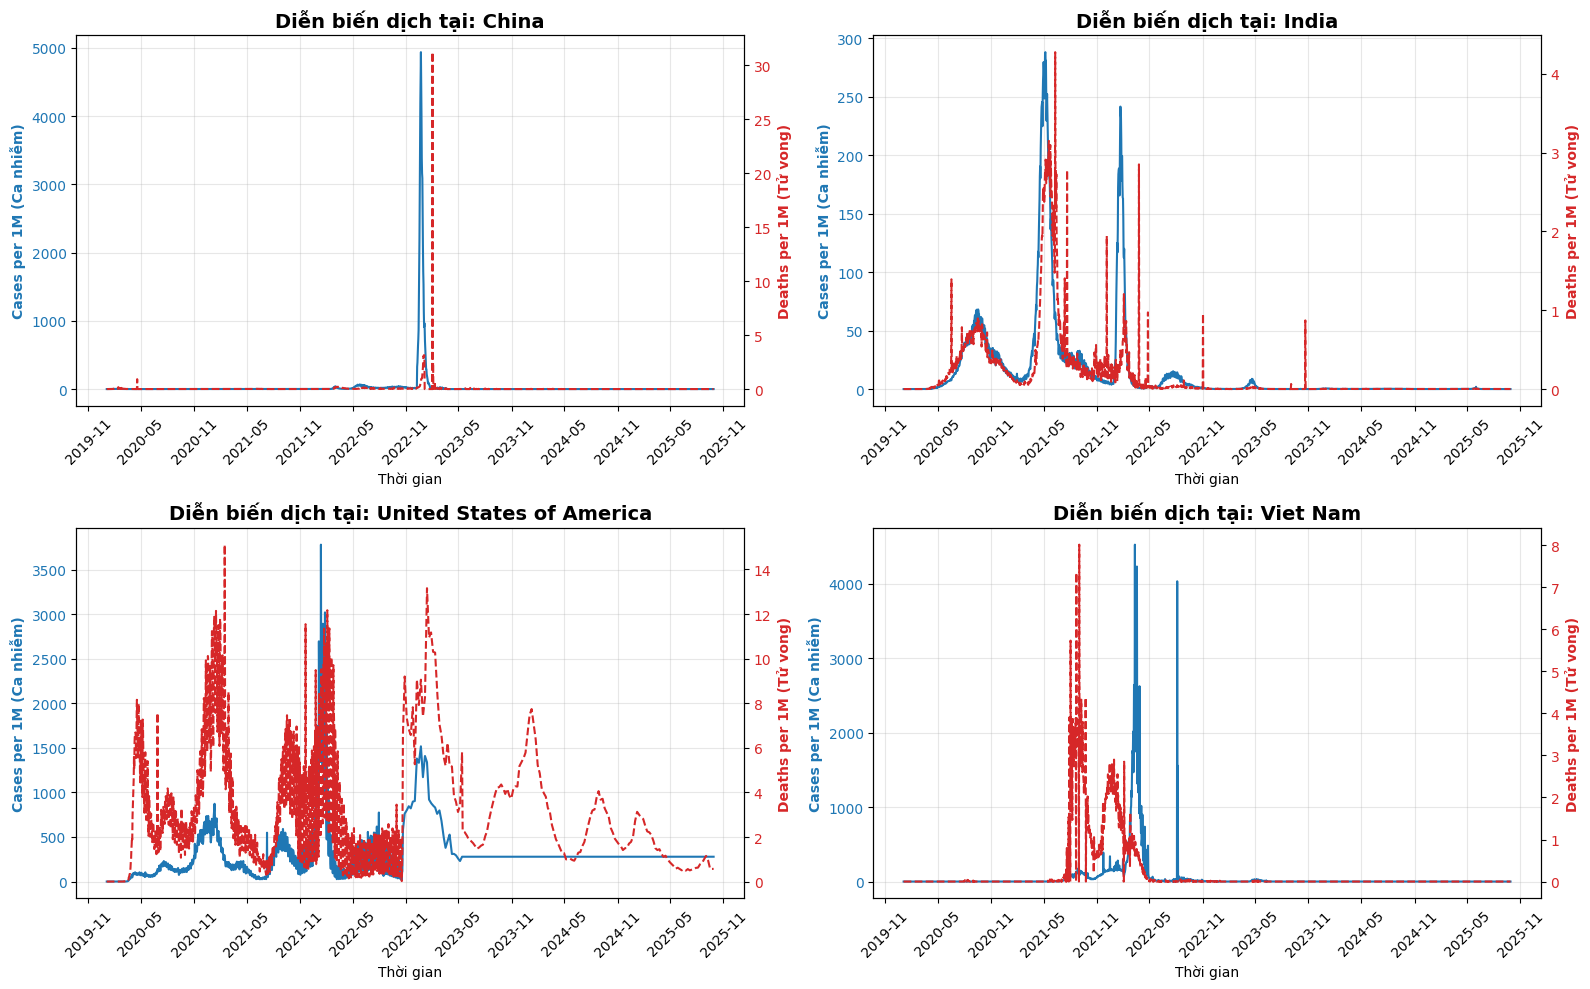

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

target_countries = df["Country"].unique()
# 4. VẼ BIỂU ĐỒ VÒNG LẶP
for i, country in enumerate(target_countries):
    ax1 = axes[i] # Lấy trục vẽ hiện tại
    
    # Lọc dữ liệu theo nước
    country_df = df[df["Country"] == country].sort_values("Date_reported")
    
    # --- VẼ TRỤC TRÁI (LEFT Y-AXIS): SỐ CA NHIỄM ---
    color1 = 'tab:blue'
    ax1.set_xlabel('Thời gian')
    ax1.set_ylabel('Cases per 1M (Ca nhiễm)', color=color1, fontweight='bold')
    ax1.plot(country_df["Date_reported"], country_df["Cases_per_1M"], color=color1, label='Cases/1M')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3) 

    # --- VẼ TRỤC PHẢI (RIGHT Y-AXIS): SỐ CA TỬ VONG ---
    ax2 = ax1.twinx()  
    color2 = 'tab:red'
    ax2.set_ylabel('Deaths per 1M (Tử vong)', color=color2, fontweight='bold')
    ax2.plot(country_df["Date_reported"], country_df["Deaths_per_1M"], color=color2, linestyle='--', label='Deaths/1M')
    ax2.tick_params(axis='y', labelcolor=color2)

    ax1.set_title(f"Diễn biến dịch tại: {country}", fontsize=14, fontweight='bold')
    
    # Định dạng ngày tháng trục X
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6)) # 6 tháng hiện mốc 1 lần cho đỡ rối
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Lưu và hiển thị
plt.savefig("../results/charts/covid19_cases_vs_deaths_4_countries.png")
plt.show()
plt.close()


**Nhận diện "Độ trễ tử vong" (Lag Time):**

* Quan sát biểu đồ tại Mỹ và Ấn Độ, đỉnh dịch tử vong (đường nét đứt màu đỏ) thường xuất hiện sau đỉnh dịch lây nhiễm (đường màu xanh) khoảng 2-3 tuần. -> Đây là minh chứng cho việc cần dùng Lag Features trong mô hình dự báo.

**Đánh giá hiệu quả y tế:**

* Nếu đường màu xanh (Ca nhiễm) tăng vọt nhưng đường màu đỏ (Tử vong) không tăng tương ứng (khoảng cách giữa 2 đường nới rộng) -> Giai đoạn này tỷ lệ tử vong giảm, có thể do phủ sóng vắc-xin hoặc biến chủng mới ít độc lực hơn.

### 4.3.3. Tương quan & Cơ sở chọn mô hình (Quan trọng nhất cho ML)


#### BIỂU ĐỒ: ACF/PACF
Mục đích: Kiểm tra sự phụ thuộc vào quá khứ (Lag)

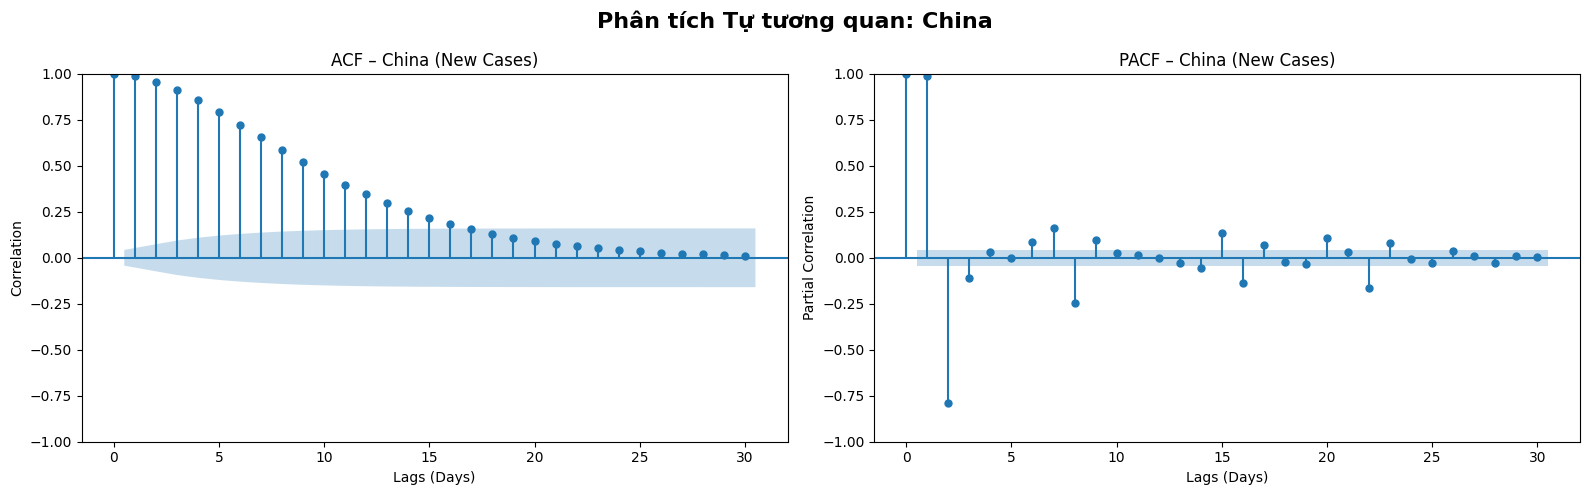

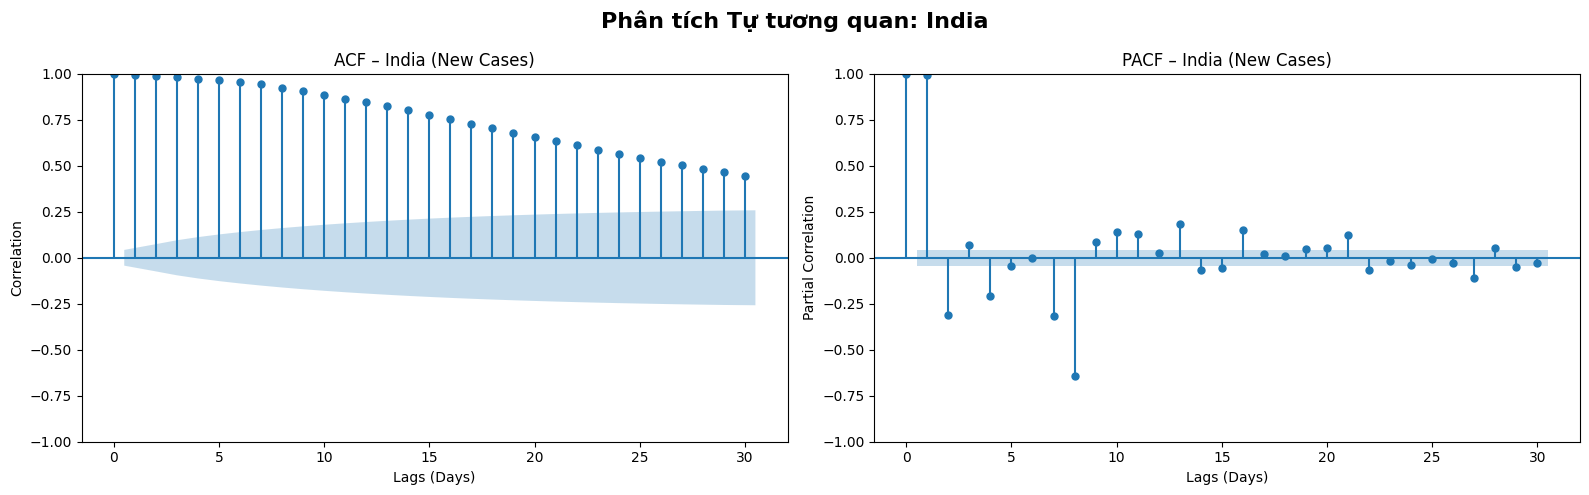

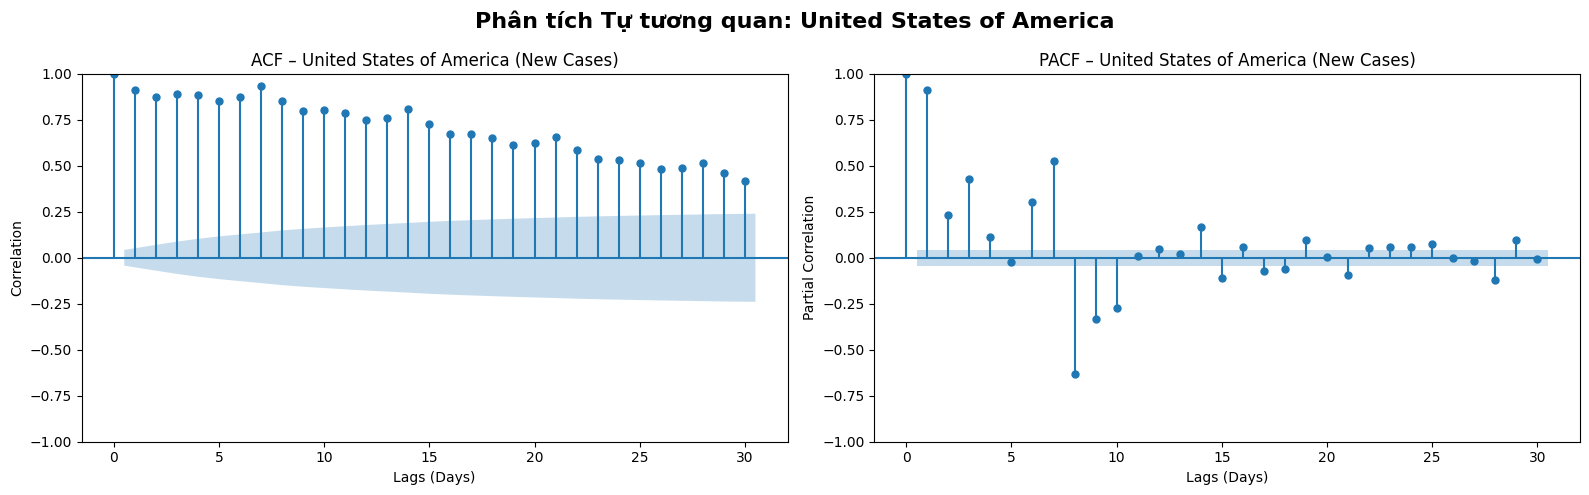

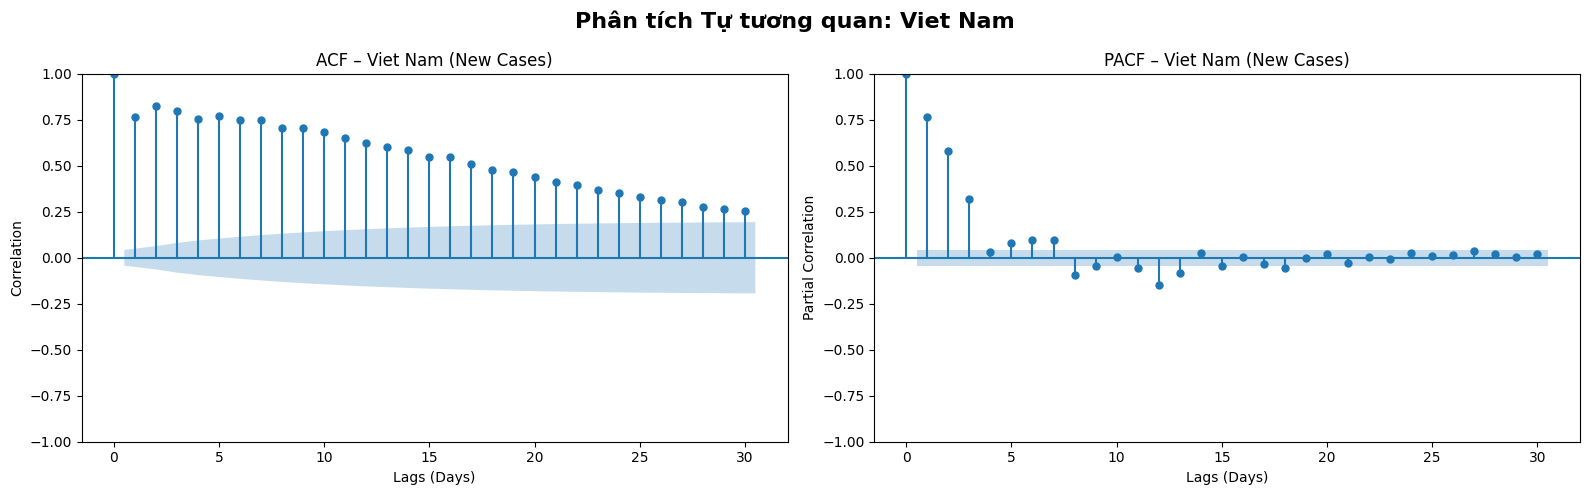

In [22]:
for c in target_countries:
    # Lấy dữ liệu và bỏ NaN
    sub = df[df["Country"] == c]["New_cases"].dropna()
    
    # Kiểm tra nếu dữ liệu quá ít thì bỏ qua để tránh lỗi
    if len(sub) < 30:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Vẽ ACF bên trái
    plot_acf(sub, lags=30, ax=axes[0], title=f"ACF – {c} (New Cases)")
    axes[0].set_xlabel('Lags (Days)')
    axes[0].set_ylabel('Correlation')

    # Vẽ PACF bên phải
    plot_pacf(sub, lags=30, method="ywm", ax=axes[1], title=f"PACF – {c} (New Cases)")
    axes[1].set_xlabel('Lags (Days)')
    axes[1].set_ylabel('Partial Correlation')

    plt.suptitle(f"Phân tích Tự tương quan: {c}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Lưu file
    filename = f"../results/charts/acf_pacf_{c.replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()

**Nhận xét:**

* Biểu đồ ACF (bên trái) của các quốc gia đều cho thấy sự giảm dần chậm chạp (slow decay), điều này khẳng định dữ liệu chuỗi thời gian có xu hướng rõ rệt và không dừng.

* Trong khi đó, biểu đồ PACF (bên phải) thường có các đỉnh cao đột biến ở Lag 1 và Lag 7.

-> Điều này chứng minh mối quan hệ tự hồi quy mạnh mẽ: số ca nhiễm hôm nay phụ thuộc rất lớn vào số ca hôm qua và số ca cùng ngày tuần trước

-> Đây là bằng chứng thống kê vững chắc để sử dụng các biến trễ (Lag features) làm đầu vào cho mô hình dự báo.

#### BIỂU ĐỒ: HEATMAP TƯƠNG QUAN
Mục đích: Chứng minh Feature Engineering là hiệu quả

In [25]:
# Tạo tạm các features để vẽ tương quan
corr_df = df[['New_cases']].copy()
corr_df['lag_1'] = corr_df['New_cases'].shift(1)
corr_df['lag_7'] = corr_df['New_cases'].shift(7)
corr_df['ma_7'] = corr_df['New_cases'].rolling(7).mean()
corr_df['ma_14'] = corr_df['New_cases'].rolling(14).mean()
corr_df = corr_df.dropna()

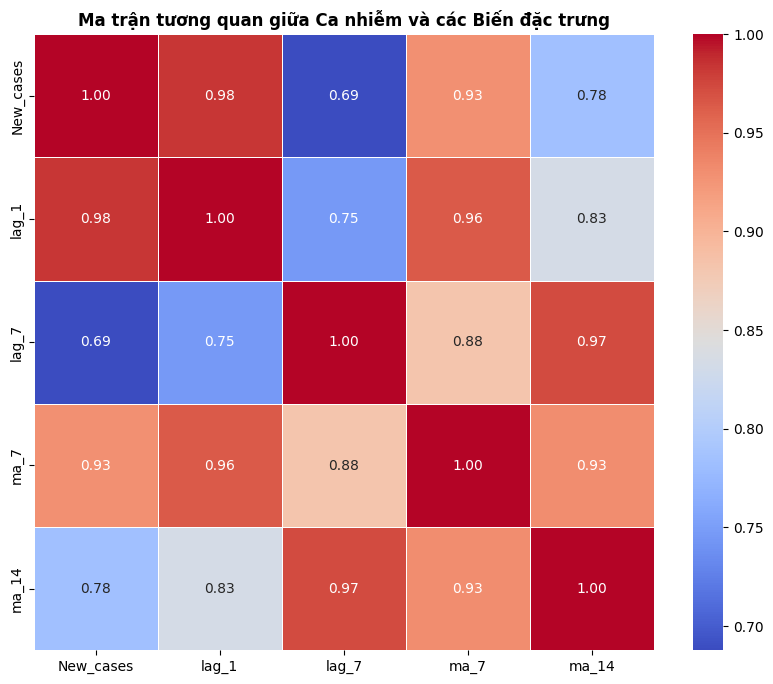

In [26]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Ma trận tương quan giữa Ca nhiễm và các Biến đặc trưng', fontweight='bold')
plt.show()

**Nhận xét:**
* Biểu đồ nhiệt (Heatmap) chỉ ra mối tương quan tuyến tính gần như tuyệt đối (>0.92)
giữa biến mục tiêu (new_cases) và các biến phái sinh như MA_7 hay Lag_1.

* Điều này hứa hẹn các mô hình như Random Forest hay XGBoost sẽ đạt độ chính xác cao
khi học được các mẫu hình (patterns) từ các biến này.


## Một số biểu đồ khác

In [45]:
df["Date_reported"] = pd.to_datetime(df["Date_reported"])

### BIỂU ĐỒ 10: PEAK/WAVE DETECTION

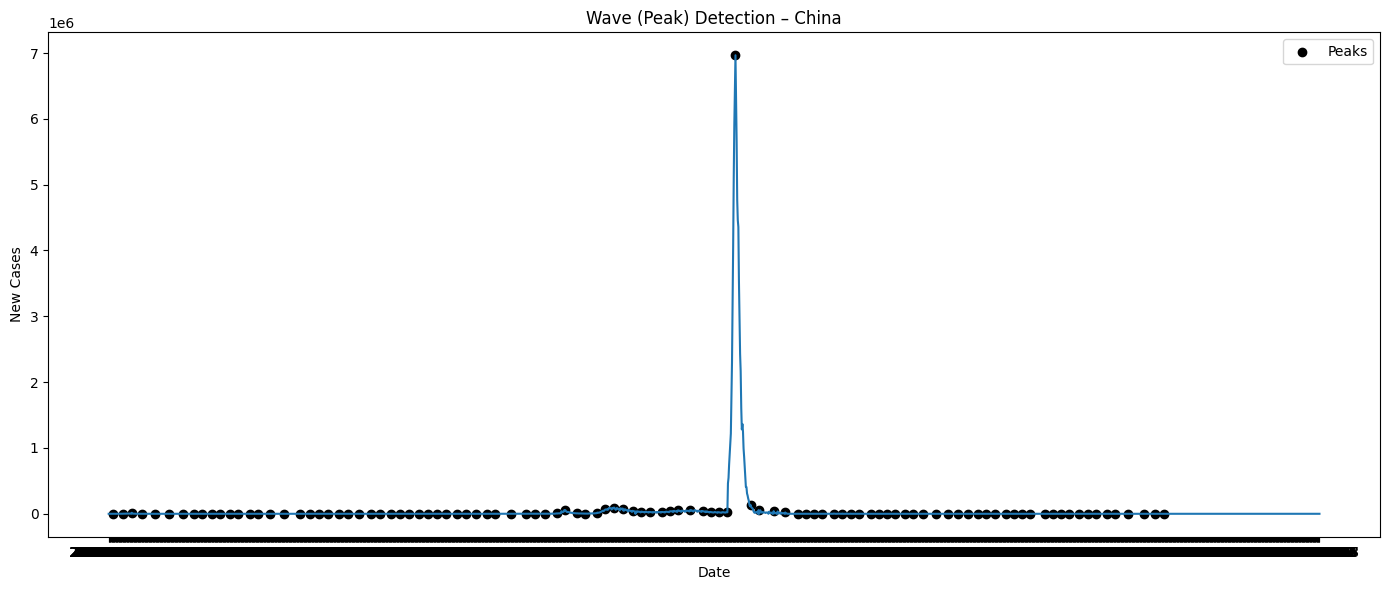

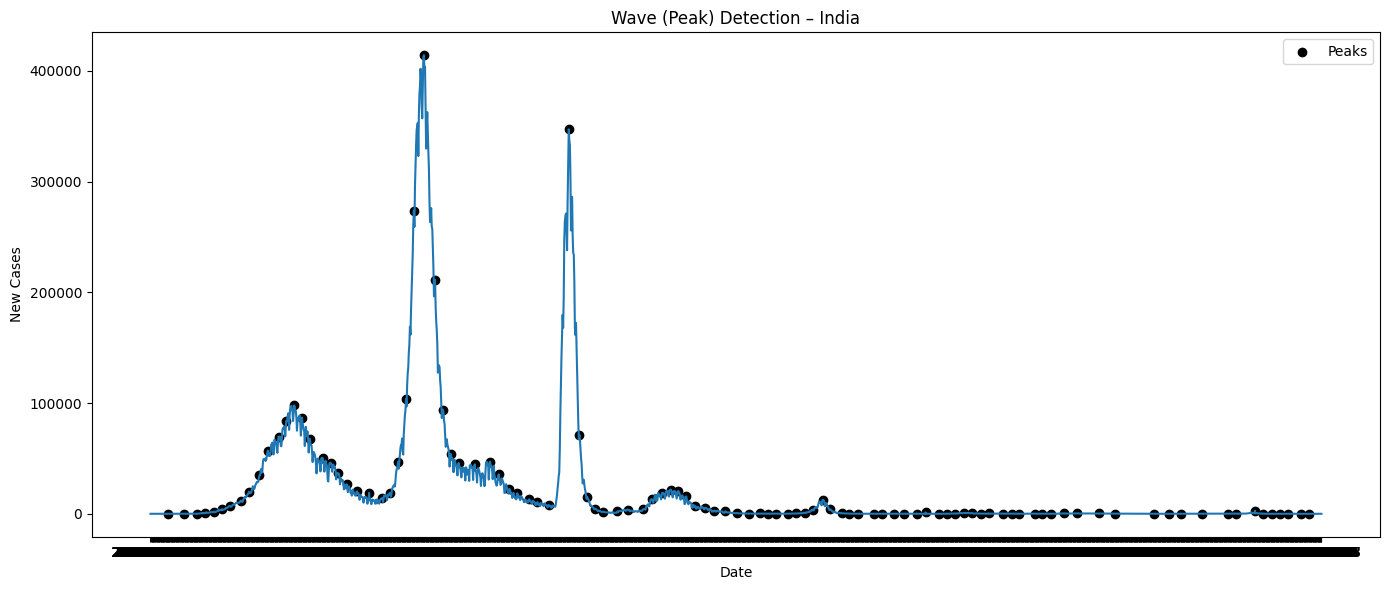

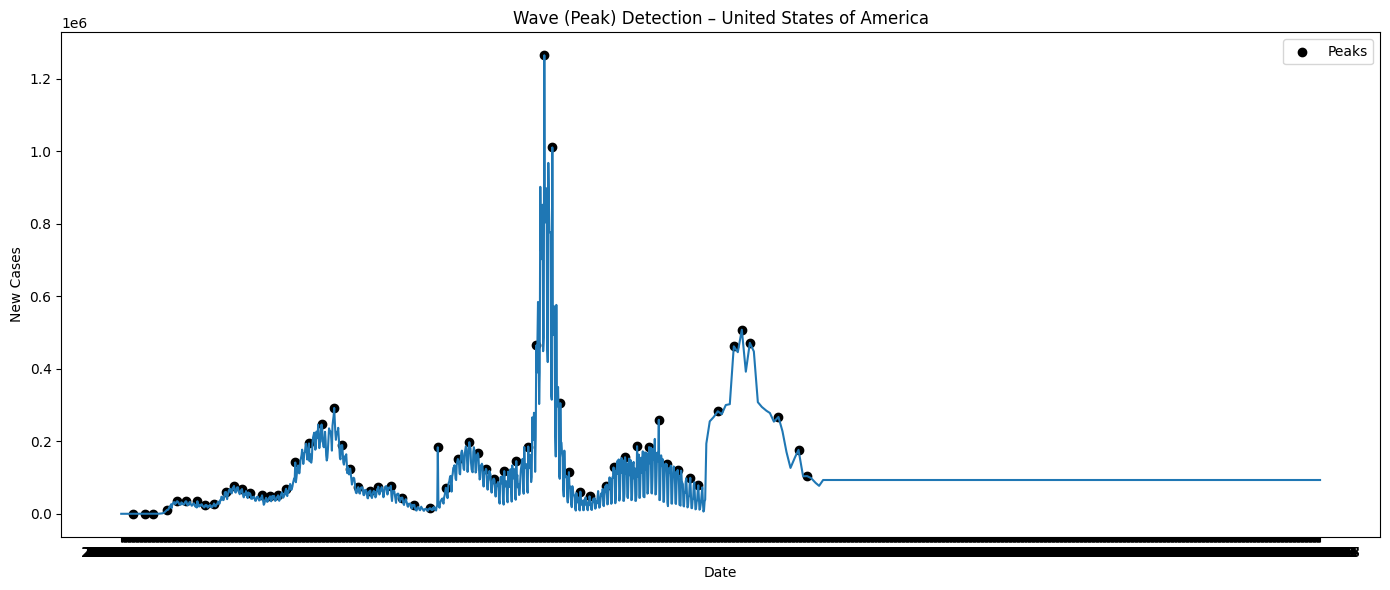

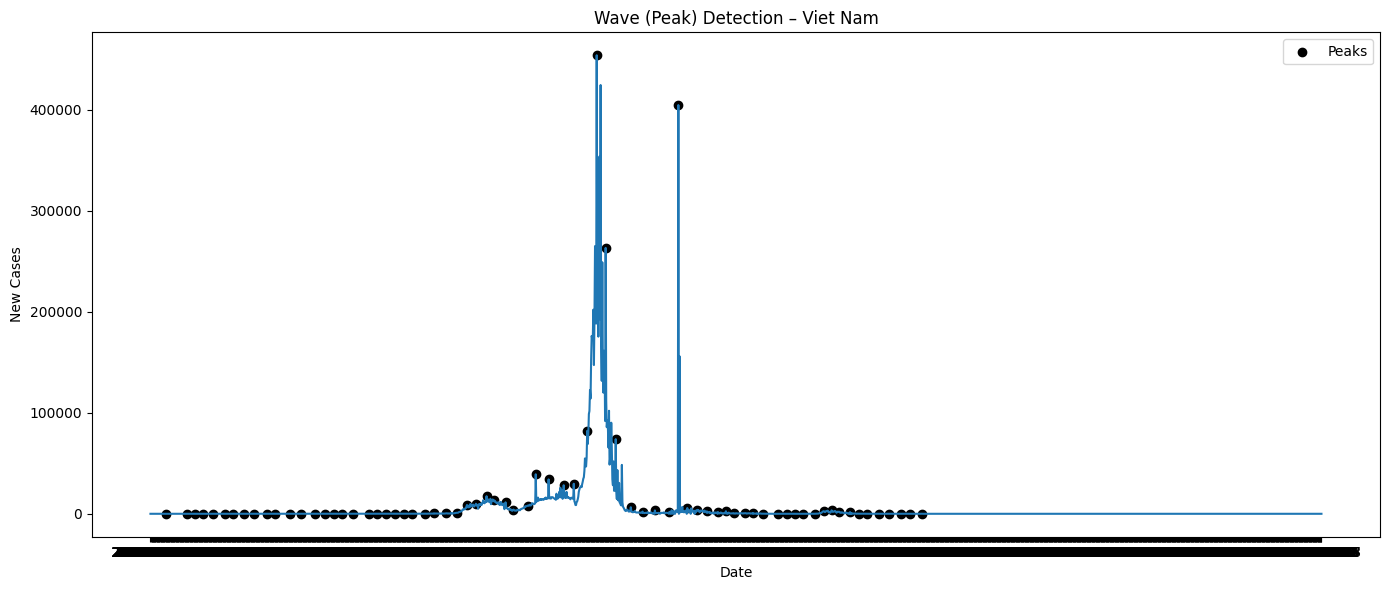

In [8]:
for c in df["Country"].unique():
    sub = df[df["Country"] == c]
    peaks, _ = find_peaks(sub["New_cases"], distance=14)

    plt.figure(figsize=(14,6))
    plt.plot(sub["Date_reported"], sub["New_cases"])
    plt.scatter(sub.iloc[peaks]["Date_reported"], sub.iloc[peaks]["New_cases"], color="black", label="Peaks")

    plt.title(f"Wave (Peak) Detection – {c}")
    plt.xlabel("Date")
    plt.ylabel("New Cases")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../results/charts/wave_detection_covid19_{c.replace(' ', '_').lower()}.png")
    plt.show()
    plt.close()

### BIỂU ĐỒ 11: CCF
Tương quan chéo giữa các quốc gia.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

def compute_ccf(x, y, max_lag=30):
    """
    Tính cross-correlation giữa hai chuỗi x và y với độ trễ tối đa ±max_lag.
    """
    x = (x - x.mean()) / x.std()
    y = (y - y.mean()) / y.std()

    full_corr = np.correlate(x, y, mode='full')
    mid = len(full_corr)//2

    # Lấy phần ±max_lag
    lags = np.arange(-max_lag, max_lag+1)
    ccf_values = full_corr[mid-max_lag:mid+max_lag+1]

    return lags, ccf_values / ccf_values.max()


In [ ]:
countries = df["Country"].unique()
def plot_ccf_between_countries(df, countries, max_lag=30):
    plt.figure(figsize=(14, 10))
    plot_idx = 1

    # Lấy danh sách cặp quốc gia
    pairs = [(a, b) for i, a in enumerate(countries) for b in countries[i+1:]]

    total = len(pairs)
    rows = int(np.ceil(total / 2))

    for (c1, c2) in pairs:
        df1 = df[df["Country"] == c1]["New_cases"].reset_index(drop=True)
        df2 = df[df["Country"] == c2]["New_cases"].reset_index(drop=True)

        # Bảo đảm độ dài bằng nhau
        min_len = min(len(df1), len(df2))
        df1 = df1[:min_len]
        df2 = df2[:min_len]

        lags, vals = compute_ccf(df1, df2, max_lag=max_lag)

        plt.subplot(rows, 2, plot_idx)
        plt.stem(lags, vals)
        plt.title(f"CCF: {c1} vs {c2} (±{max_lag} days)")
        plt.xlabel("Lag (days)")
        plt.ylabel("Correlation")
        plt.grid(alpha=0.3)

        plot_idx += 1

    plt.tight_layout()
    plt.savefig("../results/charts/ccf_between_countries.png")
    plt.show()
    plt.close()
   


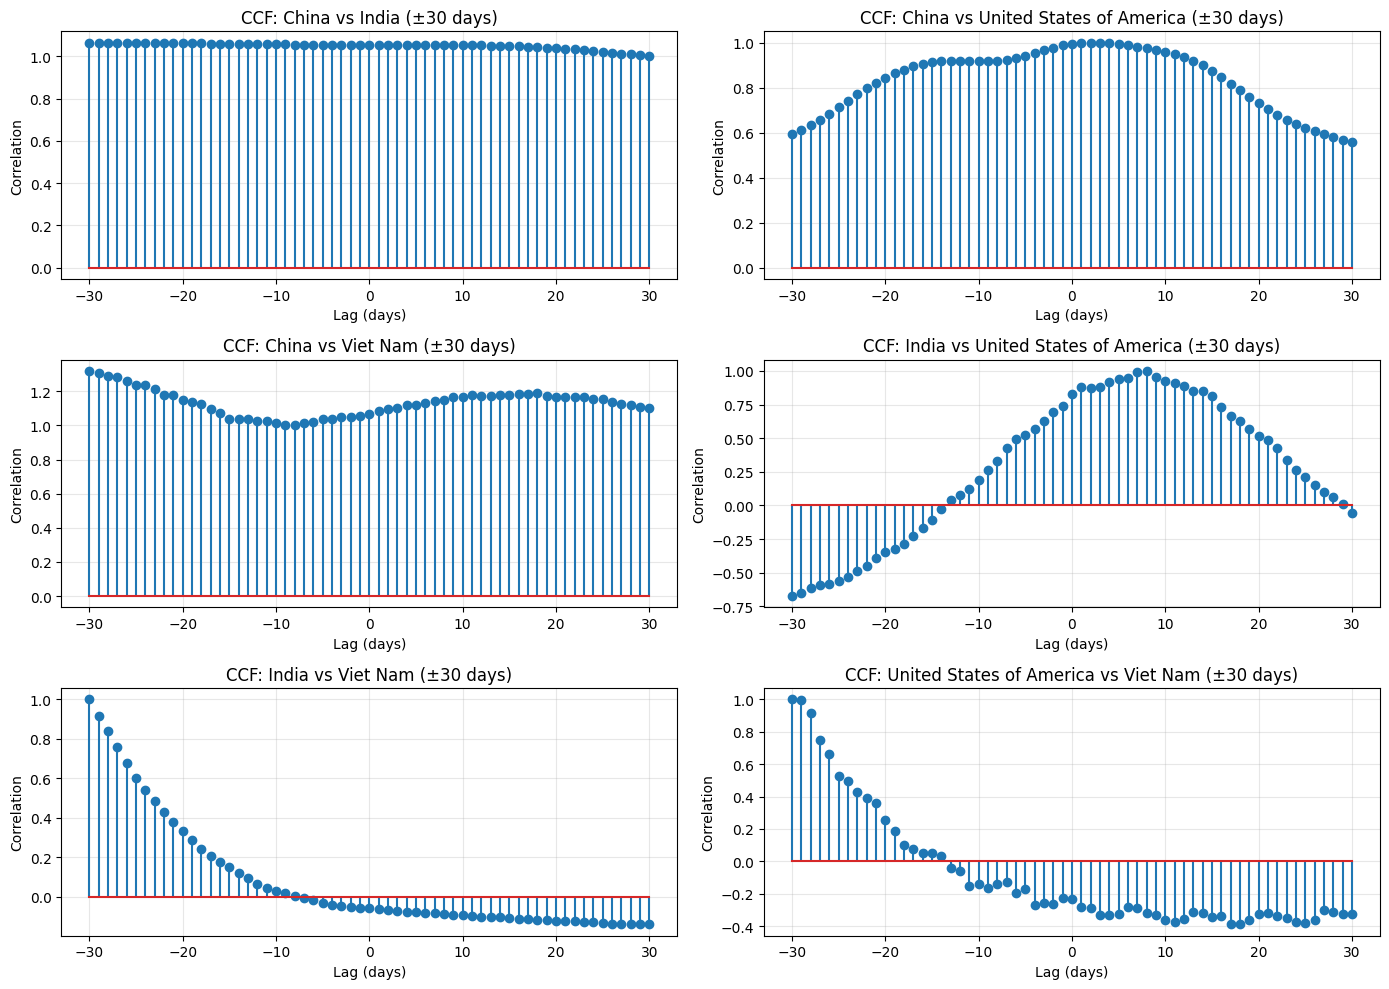

In [75]:
plot_ccf_between_countries(df, countries, max_lag=30)

## BIỂU ĐỒ CƠ BẢN


### Biểu đồ tương quan
Biểu đồ này giúp trả lời câu hỏi: "Các chỉ số có liên quan gì đến nhau không?" (Ví dụ: Số ca mắc mới có tương đồng với số ca tử vong hay mật độ dân số không?).

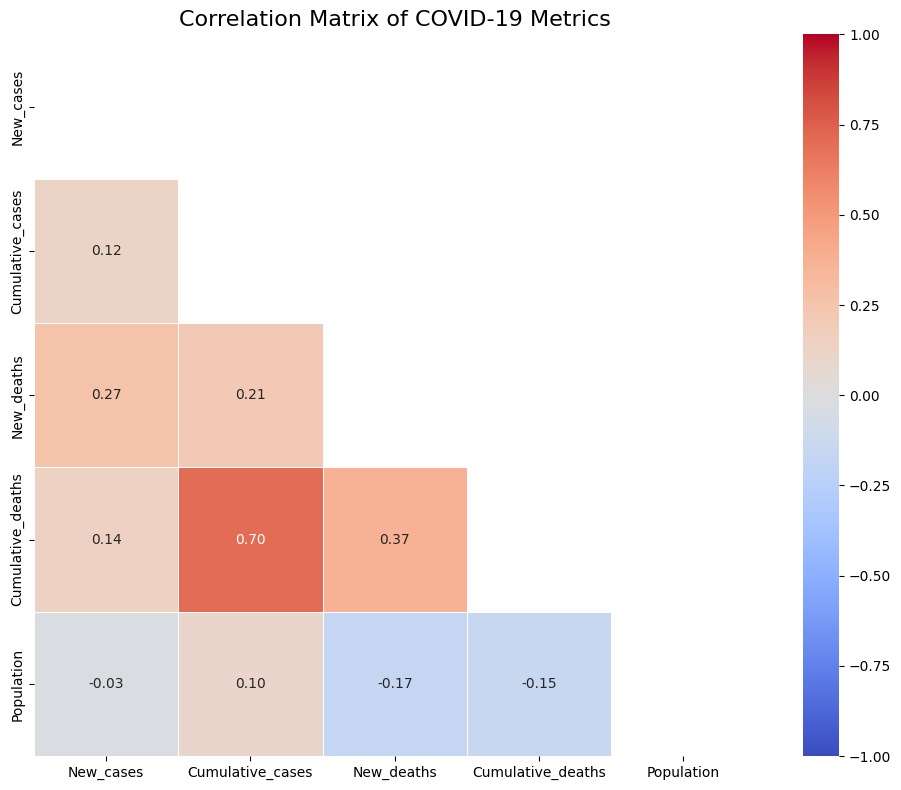

In [76]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

numeric_cols = ['New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths', 'Population']
corr_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 3. Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True,          # Hiển thị con số cụ thể
            fmt=".2f",           # Làm tròn 2 chữ số thập phân
            cmap='coolwarm',     # Màu từ Xanh (nghịch biến) sang Đỏ (đồng biến)
            vmin=-1, vmax=1,     # Cố định thang đo từ -1 đến 1
            linewidths=0.5,      # Đường viền trắng giữa các ô
            square=True)         # Ép các ô thành hình vuông cho đẹp

plt.title('Correlation Matrix of COVID-19 Metrics', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

### Biểu đồ bong bóng

In [28]:
import plotly.express as px

# 1. Lấy dữ liệu mới nhất của từng nước
df_bubble = df.groupby("Country").agg({
    "Cumulative_cases": "max",
    "Cumulative_deaths": "max",
    "Population": "max"  # Lấy dân số
}).reset_index()

# 2. Tính tỷ lệ tử vong (Case Fatality Rate - CFR) để hiển thị khi hover
df_bubble["CFR (%)"] = (df_bubble["Cumulative_deaths"] / df_bubble["Cumulative_cases"]) * 100
# 3. Vẽ biểu đồ bong bóng
fig = px.scatter(df_bubble, 
                 x="Cumulative_cases", 
                 y="Cumulative_deaths",
                 size="Population",          # Kích thước bóng theo dân số
                 color="Country",            # Mỗi nước 1 màu
                 hover_name="Country",
                 hover_data=["CFR (%)"],     # Hiện thêm tỷ lệ tử vong
                 log_x=True, log_y=True,     # Dùng thang Log để nhìn rõ cả nước lớn và nhỏ
                 size_max=60,                # Giới hạn kích thước bóng to nhất
                 title="Relationship: Cases vs. Deaths (Size = Population)")

fig.show()

### Biểu đồ Treemap (Biểu đồ cây) - Tỷ trọng toàn cầu

In [29]:
# Sắp xếp và lấy Top 20 nước (để biểu đồ đỡ bị vụn quá)
df_tree = df_bubble.sort_values("Cumulative_cases", ascending=False)
fig = px.treemap(df_tree, 
                 path=['Country'],              # Phân cấp (nếu có Châu lục thì để [Continent, Country])
                 values='Cumulative_cases',     # Diện tích ô
                 color='Cumulative_deaths',     # Màu sắc ô
                 color_continuous_scale='RdBu_r', # Đỏ đậm là chết nhiều
                 title="Top 4 Countries by Cases (Area) & Deaths (Color)")

fig.show()

### Biểu đồ Lollipop (Biểu đồ kẹo mút) - Xếp hạng chỉ số bình quân

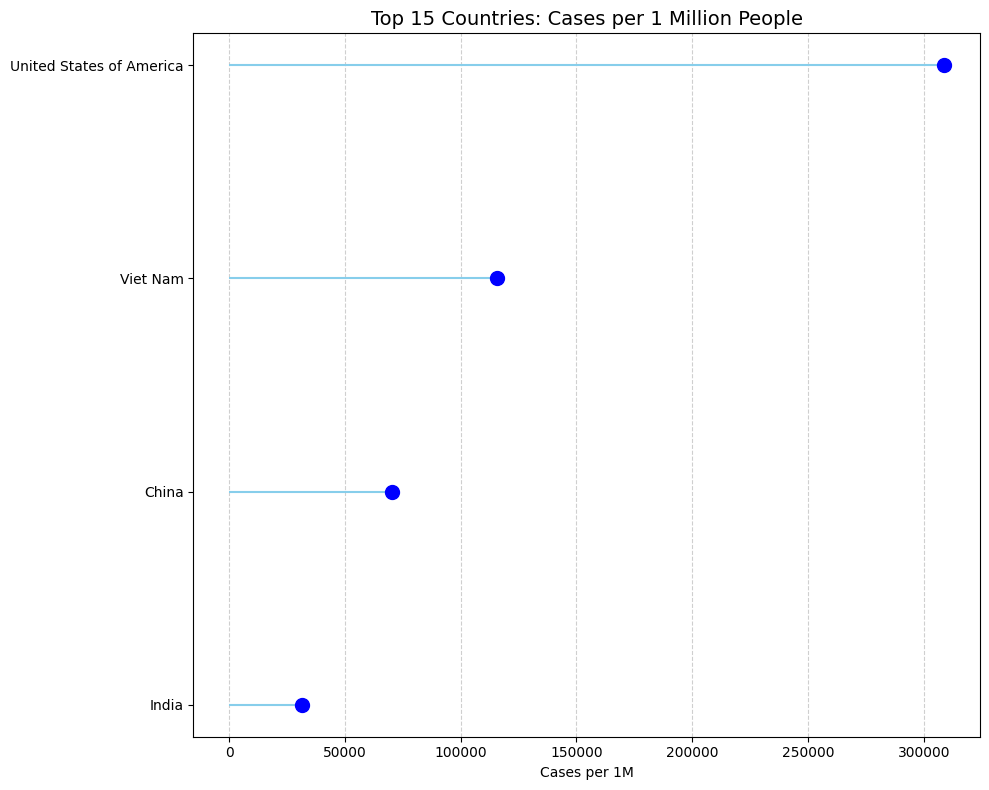

In [97]:
import matplotlib.pyplot as plt

# 1. Tính toán chỉ số Cases per 1M (nếu chưa có)
df_latest = df.groupby("Country").max().reset_index()
df_latest["Cases_per_1M"] = (df_latest["Cumulative_cases"] / df_latest["Population"]) * 1000000

# 2. Lấy Top 15 nước có tỷ lệ nhiễm cao nhất
df_lolli = df_latest.sort_values("Cases_per_1M", ascending=True).tail(15)

# 3. Vẽ biểu đồ
plt.figure(figsize=(10, 8))

# Vẽ đường que (stem)
plt.hlines(y=df_lolli["Country"], xmin=0, xmax=df_lolli["Cases_per_1M"], color='skyblue')

# Vẽ đầu kẹo (point)
plt.plot(df_lolli["Cases_per_1M"], df_lolli["Country"], "o", markersize=10, color='blue')

plt.title("Top 15 Countries: Cases per 1 Million People", fontsize=14)
plt.xlabel("Cases per 1M")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()